In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Load the data
train_data = np.load('./layer_features_base_960h/train_0.npz')
test_data = np.load('./layer_features_base_960h/test_0.npz')

train_features = train_data['features']
test_features = test_data['features']

# Read Age labels instead of Gender
train_labels = pd.read_csv('y_train.csv').Age
test_labels = pd.read_csv('y_test.csv').Age

# Encode the labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Handle unseen labels in test set by filtering out labels not present in train set
test_labels_filtered = test_labels[test_labels.isin(train_labels.unique())]
test_features_filtered = test_features[test_labels.isin(train_labels.unique())]
test_labels_encoded = label_encoder.transform(test_labels_filtered)

# Standardize features
scaler = StandardScaler()
train_features_normalized = scaler.fit_transform(train_features)
test_features_normalized = scaler.transform(test_features_filtered)

# SVM model
svm_model = SVC(kernel='linear', C=10.0, gamma='scale', random_state=42)
svm_model.fit(train_features_normalized, train_labels_encoded)

# Prediction and Evaluation
svm_predictions = svm_model.predict(test_features_normalized)
svm_accuracy = accuracy_score(test_labels_encoded, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print("SVM Classification Report:")
print(classification_report(test_labels_encoded, svm_predictions))

# CNN model (TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout

train_features_cnn = np.expand_dims(train_features_normalized, axis=-1)  # Shape: (num_samples, 768, 1)
test_features_cnn = np.expand_dims(test_features_normalized, axis=-1)    # Shape: (num_samples, 768, 1)

cnn_model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(768, 1)),  # Update input shape to 768 features
    Conv1D(128, kernel_size=5, activation='relu'),
    Conv1D(256, kernel_size=5, activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model.fit(train_features_cnn, train_labels_encoded, epochs=50, batch_size=32, validation_split=0.2)

cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(test_features_cnn, test_labels_encoded)
print(f"CNN Test Accuracy: {cnn_test_accuracy:.4f}")

# ANN model (TensorFlow)
ann_model = Sequential([
    Dense(512, activation='relu', input_shape=(768,)),  # Update input shape to 768 features
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

ann_model.fit(train_features_normalized, train_labels_encoded, epochs=50, batch_size=32, validation_split=0.2)

ann_test_loss, ann_test_accuracy = ann_model.evaluate(test_features_normalized, test_labels_encoded)
print(f"ANN Test Accuracy: {ann_test_accuracy:.4f}")

# PyTorch CNN Model
import torch
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(train_features_cnn, dtype=torch.float32).permute(0, 2, 1)  # Shape: (num_samples, 1, 768)
y_train_tensor = torch.tensor(train_labels_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(test_features_cnn, dtype=torch.float32).permute(0, 2, 1)    # Shape: (num_samples, 1, 768)
y_test_tensor = torch.tensor(test_labels_encoded, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

import torch.nn as nn
import torch.optim as optim

class CNN1DModel(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNN1DModel, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 768, 512)  # Update to 768 features
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

input_channels = 1
num_classes = len(label_encoder.classes_)
model = CNN1DModel(input_channels, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and testing as before


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


SVM Accuracy: 0.7874
SVM Classification Report:
              precision    recall  f1-score   support

           1       0.69      0.75      0.72        12
           2       0.50      0.50      0.50         8
           3       0.84      0.92      0.88        39
           4       0.86      1.00      0.92         6
           5       0.80      0.79      0.80        42
           6       0.80      0.50      0.62        16
           7       0.67      1.00      0.80         2
           8       1.00      1.00      1.00         2

    accuracy                           0.79       127
   macro avg       0.77      0.81      0.78       127
weighted avg       0.79      0.79      0.78       127



2024-09-08 17:21:46.556100: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-08 17:21:47.461214: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/50


/home/mojo/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-09-08 17:21:48.272855: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-08 17:21:48.291049: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and set

22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 365ms/step - accuracy: 0.3157 - loss: 3.0772 - val_accuracy: 0.0465 - val_loss: 4.0797
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 356ms/step - accuracy: 0.7316 - loss: 0.8635 - val_accuracy: 0.1047 - val_loss: 3.1800
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 359ms/step - accuracy: 0.8640 - loss: 0.3741 - val_accuracy: 0.1686 - val_loss: 3.4819
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 350ms/step - accuracy: 0.9624 - loss: 0.1427 - val_accuracy: 0.1453 - val_loss: 4.9774
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 347ms/step - accuracy: 0.9572 - loss: 0.1104 - val_accuracy: 0.1570 - val_loss: 5.3400
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 345ms/step - accuracy: 0.9784 - loss: 0.0512 - val_accuracy: 0.2267 - val_loss: 5.0027
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 349ms/step - accuracy: 0.9876 - loss: 0.0357 - val_accuracy: 0.2035 - val_loss: 4.9064
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 348ms/step - accuracy: 0.9921 - loss: 0.0411 - val_accuracy: 0.1570 - val_

/home/mojo/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2448 - loss: 2.7834 - val_accuracy: 0.0407 - val_loss: 2.2815
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3970 - loss: 1.8079 - val_accuracy: 0.0756 - val_loss: 2.1231
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5222 - loss: 1.5004 - val_accuracy: 0.0581 - val_loss: 2.3332
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6071 - loss: 1.1474 - val_accuracy: 0.1628 - val_loss: 2.1380
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6575 - loss: 1.0440 - val_accuracy: 0.2209 - val_loss: 2.1312
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6617 - loss: 1.1380 - val_accuracy: 0.1628 - val_loss: 2.5671
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7178 - loss: 0.8536 - val_accuracy: 0.2849 - val_loss: 2.3034
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6893 - loss: 0.8740 - val_accuracy: 0.2500 - val_loss: 2.4500
Epo

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Load the data
train_data = np.load('./layer_features_base_960h/train_1.npz')
test_data = np.load('./layer_features_base_960h/test_1.npz')

train_features = train_data['features']
test_features = test_data['features']

# Read Age labels instead of Gender
train_labels = pd.read_csv('y_train.csv').Age
test_labels = pd.read_csv('y_test.csv').Age

# Encode the labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Handle unseen labels in test set by filtering out labels not present in train set
test_labels_filtered = test_labels[test_labels.isin(train_labels.unique())]
test_features_filtered = test_features[test_labels.isin(train_labels.unique())]
test_labels_encoded = label_encoder.transform(test_labels_filtered)

# Standardize features
scaler = StandardScaler()
train_features_normalized = scaler.fit_transform(train_features)
test_features_normalized = scaler.transform(test_features_filtered)

# SVM model
svm_model = SVC(kernel='linear', C=10.0, gamma='scale', random_state=42)
svm_model.fit(train_features_normalized, train_labels_encoded)

# Prediction and Evaluation
svm_predictions = svm_model.predict(test_features_normalized)
svm_accuracy = accuracy_score(test_labels_encoded, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print("SVM Classification Report:")
print(classification_report(test_labels_encoded, svm_predictions))

# CNN model (TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout

train_features_cnn = np.expand_dims(train_features_normalized, axis=-1)  # Shape: (num_samples, 768, 1)
test_features_cnn = np.expand_dims(test_features_normalized, axis=-1)    # Shape: (num_samples, 768, 1)

cnn_model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(768, 1)),  # Update input shape to 768 features
    Conv1D(128, kernel_size=5, activation='relu'),
    Conv1D(256, kernel_size=5, activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model.fit(train_features_cnn, train_labels_encoded, epochs=50, batch_size=32, validation_split=0.2)

cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(test_features_cnn, test_labels_encoded)
print(f"CNN Test Accuracy: {cnn_test_accuracy:.4f}")

# ANN model (TensorFlow)
ann_model = Sequential([
    Dense(512, activation='relu', input_shape=(768,)),  # Update input shape to 768 features
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

ann_model.fit(train_features_normalized, train_labels_encoded, epochs=50, batch_size=32, validation_split=0.2)

ann_test_loss, ann_test_accuracy = ann_model.evaluate(test_features_normalized, test_labels_encoded)
print(f"ANN Test Accuracy: {ann_test_accuracy:.4f}")

# PyTorch CNN Model
import torch
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(train_features_cnn, dtype=torch.float32).permute(0, 2, 1)  # Shape: (num_samples, 1, 768)
y_train_tensor = torch.tensor(train_labels_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(test_features_cnn, dtype=torch.float32).permute(0, 2, 1)    # Shape: (num_samples, 1, 768)
y_test_tensor = torch.tensor(test_labels_encoded, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

import torch.nn as nn
import torch.optim as optim

class CNN1DModel(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNN1DModel, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 768, 512)  # Update to 768 features
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

input_channels = 1
num_classes = len(label_encoder.classes_)
model = CNN1DModel(input_channels, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and testing as before


SVM Accuracy: 0.8583
SVM Classification Report:
              precision    recall  f1-score   support

           1       0.83      0.83      0.83        12
           2       0.86      0.75      0.80         8
           3       0.83      0.97      0.89        39
           4       1.00      1.00      1.00         6
           5       0.86      0.86      0.86        42
           6       1.00      0.56      0.72        16
           7       0.67      1.00      0.80         2
           8       1.00      1.00      1.00         2

    accuracy                           0.86       127
   macro avg       0.88      0.87      0.86       127
weighted avg       0.87      0.86      0.85       127

Epoch 1/50


/home/mojo/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 345ms/step - accuracy: 0.3357 - loss: 2.8946 - val_accuracy: 0.3953 - val_loss: 1.8562
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 334ms/step - accuracy: 0.8011 - loss: 0.5673 - val_accuracy: 0.1686 - val_loss: 3.8049
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 334ms/step - accuracy: 0.9354 - loss: 0.2019 - val_accuracy: 0.2209 - val_loss: 4.5423
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 335ms/step - accuracy: 0.9804 - loss: 0.0673 - val_accuracy: 0.1453 - val_loss: 7.6773
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 340ms/step - accuracy: 0.9836 - loss: 0.0685 - val_accuracy: 0.3256 - val_loss: 4.4402
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 337ms/step - accuracy: 0.9972 - loss: 0.0212 - val_accuracy: 0.2093 - val_loss: 6.2420
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 337ms/step - accuracy: 0.9900 - loss: 0.0452 - val_accuracy: 0.1919 - val_loss: 5.6889
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 337ms/step - accuracy: 0.9887 - loss: 0.0587 - val_accuracy: 0.2326 - val

/home/mojo/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2732 - loss: 2.8772 - val_accuracy: 0.0814 - val_loss: 2.1314
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4488 - loss: 1.7445 - val_accuracy: 0.2616 - val_loss: 1.9903
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5165 - loss: 1.4535 - val_accuracy: 0.2791 - val_loss: 2.1066
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5708 - loss: 1.3121 - val_accuracy: 0.3081 - val_loss: 1.9813
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6442 - loss: 1.1347 - val_accuracy: 0.3023 - val_loss: 2.1314
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7043 - loss: 0.9124 - val_accuracy: 0.3372 - val_loss: 2.1929
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7519 - loss: 0.7567 - val_accuracy: 0.2674 - val_loss: 2.3769
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7930 - loss: 0.6856 - val_accuracy: 0.3837 - val_loss: 1.9911
Epo

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Load the data
train_data = np.load('./layer_features_base_960h/train_2.npz')
test_data = np.load('./layer_features_base_960h/test_2.npz')

train_features = train_data['features']
test_features = test_data['features']

# Read Age labels instead of Gender
train_labels = pd.read_csv('y_train.csv').Age
test_labels = pd.read_csv('y_test.csv').Age

# Encode the labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Handle unseen labels in test set by filtering out labels not present in train set
test_labels_filtered = test_labels[test_labels.isin(train_labels.unique())]
test_features_filtered = test_features[test_labels.isin(train_labels.unique())]
test_labels_encoded = label_encoder.transform(test_labels_filtered)

# Standardize features
scaler = StandardScaler()
train_features_normalized = scaler.fit_transform(train_features)
test_features_normalized = scaler.transform(test_features_filtered)

# SVM model
svm_model = SVC(kernel='linear', C=10.0, gamma='scale', random_state=42)
svm_model.fit(train_features_normalized, train_labels_encoded)

# Prediction and Evaluation
svm_predictions = svm_model.predict(test_features_normalized)
svm_accuracy = accuracy_score(test_labels_encoded, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print("SVM Classification Report:")
print(classification_report(test_labels_encoded, svm_predictions))

# CNN model (TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout

train_features_cnn = np.expand_dims(train_features_normalized, axis=-1)  # Shape: (num_samples, 768, 1)
test_features_cnn = np.expand_dims(test_features_normalized, axis=-1)    # Shape: (num_samples, 768, 1)

cnn_model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(768, 1)),  # Update input shape to 768 features
    Conv1D(128, kernel_size=5, activation='relu'),
    Conv1D(256, kernel_size=5, activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model.fit(train_features_cnn, train_labels_encoded, epochs=50, batch_size=32, validation_split=0.2)

cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(test_features_cnn, test_labels_encoded)
print(f"CNN Test Accuracy: {cnn_test_accuracy:.4f}")

# ANN model (TensorFlow)
ann_model = Sequential([
    Dense(512, activation='relu', input_shape=(768,)),  # Update input shape to 768 features
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

ann_model.fit(train_features_normalized, train_labels_encoded, epochs=50, batch_size=32, validation_split=0.2)

ann_test_loss, ann_test_accuracy = ann_model.evaluate(test_features_normalized, test_labels_encoded)
print(f"ANN Test Accuracy: {ann_test_accuracy:.4f}")

# PyTorch CNN Model
import torch
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(train_features_cnn, dtype=torch.float32).permute(0, 2, 1)  # Shape: (num_samples, 1, 768)
y_train_tensor = torch.tensor(train_labels_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(test_features_cnn, dtype=torch.float32).permute(0, 2, 1)    # Shape: (num_samples, 1, 768)
y_test_tensor = torch.tensor(test_labels_encoded, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

import torch.nn as nn
import torch.optim as optim

class CNN1DModel(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNN1DModel, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 768, 512)  # Update to 768 features
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

input_channels = 1
num_classes = len(label_encoder.classes_)
model = CNN1DModel(input_channels, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and testing as before


SVM Accuracy: 0.8504
SVM Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.83      0.91        12
           2       0.75      0.75      0.75         8
           3       0.80      0.95      0.87        39
           4       0.75      1.00      0.86         6
           5       0.88      0.86      0.87        42
           6       0.90      0.56      0.69        16
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2

    accuracy                           0.85       127
   macro avg       0.89      0.87      0.87       127
weighted avg       0.86      0.85      0.85       127

Epoch 1/50


/home/mojo/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 351ms/step - accuracy: 0.3571 - loss: 3.5172 - val_accuracy: 0.1977 - val_loss: 2.3074
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 351ms/step - accuracy: 0.8124 - loss: 0.5498 - val_accuracy: 0.2733 - val_loss: 2.6801
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 346ms/step - accuracy: 0.9320 - loss: 0.2273 - val_accuracy: 0.3663 - val_loss: 2.8147
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 349ms/step - accuracy: 0.9727 - loss: 0.0950 - val_accuracy: 0.2209 - val_loss: 3.9458
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 348ms/step - accuracy: 0.9971 - loss: 0.0330 - val_accuracy: 0.3023 - val_loss: 3.8096
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 352ms/step - accuracy: 0.9949 - loss: 0.0356 - val_accuracy: 0.2384 - val_loss: 3.6950
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 357ms/step - accuracy: 0.9907 - loss: 0.0246 - val_accuracy: 0.3081 - val_loss: 3.7125
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 352ms/step - accuracy: 0.9963 - loss: 0.0203 - val_accuracy: 0.2326 - val_

/home/mojo/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3137 - loss: 2.6858 - val_accuracy: 0.0058 - val_loss: 2.5678
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4674 - loss: 1.7812 - val_accuracy: 0.1047 - val_loss: 2.4914
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5590 - loss: 1.3429 - val_accuracy: 0.2093 - val_loss: 2.3061
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6637 - loss: 1.0778 - val_accuracy: 0.2791 - val_loss: 2.2079
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6806 - loss: 0.9500 - val_accuracy: 0.3023 - val_loss: 2.1665
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7238 - loss: 0.8080 - val_accuracy: 0.3372 - val_loss: 2.1859
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7460 - loss: 0.7439 - val_accuracy: 0.3488 - val_loss: 2.3061
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8178 - loss: 0.5312 - val_accuracy: 0.4070 - val_loss: 2.2105
Epo

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Load the data
train_data = np.load('./layer_features_base_960h/train_3.npz')
test_data = np.load('./layer_features_base_960h/test_3.npz')

train_features = train_data['features']
test_features = test_data['features']

# Read Age labels instead of Gender
train_labels = pd.read_csv('y_train.csv').Age
test_labels = pd.read_csv('y_test.csv').Age

# Encode the labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Handle unseen labels in test set by filtering out labels not present in train set
test_labels_filtered = test_labels[test_labels.isin(train_labels.unique())]
test_features_filtered = test_features[test_labels.isin(train_labels.unique())]
test_labels_encoded = label_encoder.transform(test_labels_filtered)

# Standardize features
scaler = StandardScaler()
train_features_normalized = scaler.fit_transform(train_features)
test_features_normalized = scaler.transform(test_features_filtered)

# SVM model
svm_model = SVC(kernel='linear', C=10.0, gamma='scale', random_state=42)
svm_model.fit(train_features_normalized, train_labels_encoded)

# Prediction and Evaluation
svm_predictions = svm_model.predict(test_features_normalized)
svm_accuracy = accuracy_score(test_labels_encoded, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print("SVM Classification Report:")
print(classification_report(test_labels_encoded, svm_predictions))

# CNN model (TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout

train_features_cnn = np.expand_dims(train_features_normalized, axis=-1)  # Shape: (num_samples, 768, 1)
test_features_cnn = np.expand_dims(test_features_normalized, axis=-1)    # Shape: (num_samples, 768, 1)

cnn_model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(768, 1)),  # Update input shape to 768 features
    Conv1D(128, kernel_size=5, activation='relu'),
    Conv1D(256, kernel_size=5, activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model.fit(train_features_cnn, train_labels_encoded, epochs=50, batch_size=32, validation_split=0.2)

cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(test_features_cnn, test_labels_encoded)
print(f"CNN Test Accuracy: {cnn_test_accuracy:.4f}")

# ANN model (TensorFlow)
ann_model = Sequential([
    Dense(512, activation='relu', input_shape=(768,)),  # Update input shape to 768 features
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

ann_model.fit(train_features_normalized, train_labels_encoded, epochs=50, batch_size=32, validation_split=0.2)

ann_test_loss, ann_test_accuracy = ann_model.evaluate(test_features_normalized, test_labels_encoded)
print(f"ANN Test Accuracy: {ann_test_accuracy:.4f}")

# PyTorch CNN Model
import torch
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(train_features_cnn, dtype=torch.float32).permute(0, 2, 1)  # Shape: (num_samples, 1, 768)
y_train_tensor = torch.tensor(train_labels_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(test_features_cnn, dtype=torch.float32).permute(0, 2, 1)    # Shape: (num_samples, 1, 768)
y_test_tensor = torch.tensor(test_labels_encoded, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

import torch.nn as nn
import torch.optim as optim

class CNN1DModel(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNN1DModel, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 768, 512)  # Update to 768 features
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

input_channels = 1
num_classes = len(label_encoder.classes_)
model = CNN1DModel(input_channels, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and testing as before


SVM Accuracy: 0.8898
SVM Classification Report:
              precision    recall  f1-score   support

           1       0.91      0.83      0.87        12
           2       0.78      0.88      0.82         8
           3       0.87      1.00      0.93        39
           4       1.00      1.00      1.00         6
           5       0.90      0.90      0.90        42
           6       0.90      0.56      0.69        16
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2

    accuracy                           0.89       127
   macro avg       0.92      0.90      0.90       127
weighted avg       0.89      0.89      0.88       127

Epoch 1/50


/home/mojo/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 372ms/step - accuracy: 0.3627 - loss: 2.8811 - val_accuracy: 0.4186 - val_loss: 1.5319
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 360ms/step - accuracy: 0.8424 - loss: 0.4827 - val_accuracy: 0.3198 - val_loss: 2.4800
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 361ms/step - accuracy: 0.9680 - loss: 0.1408 - val_accuracy: 0.2035 - val_loss: 3.8111
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 358ms/step - accuracy: 0.9873 - loss: 0.0628 - val_accuracy: 0.2267 - val_loss: 3.8456
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 358ms/step - accuracy: 0.9937 - loss: 0.0306 - val_accuracy: 0.3081 - val_loss: 3.0564
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 359ms/step - accuracy: 0.9990 - loss: 0.0167 - val_accuracy: 0.2733 - val_loss: 3.9437
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 357ms/step - accuracy: 0.9980 - loss: 0.0111 - val_accuracy: 0.2849 - val_loss: 3.7745
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 357ms/step - accuracy: 0.9977 - loss: 0.0064 - val_accuracy: 0.3488 - val_

/home/mojo/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2485 - loss: 3.0386 - val_accuracy: 0.0640 - val_loss: 2.2277
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4549 - loss: 1.6887 - val_accuracy: 0.1686 - val_loss: 2.2179
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5351 - loss: 1.5303 - val_accuracy: 0.3081 - val_loss: 2.0016
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5687 - loss: 1.0992 - val_accuracy: 0.3547 - val_loss: 2.1092
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6638 - loss: 0.9482 - val_accuracy: 0.2907 - val_loss: 2.3329
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7460 - loss: 0.7550 - val_accuracy: 0.3372 - val_loss: 2.3549
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7763 - loss: 0.6610 - val_accuracy: 0.2965 - val_loss: 2.5506
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7769 - loss: 0.6444 - val_accuracy: 0.3663 - val_loss: 2.6948
Epo

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Load the data
train_data = np.load('./layer_features_base_960h/train_4.npz')
test_data = np.load('./layer_features_base_960h/test_4.npz')

train_features = train_data['features']
test_features = test_data['features']

# Read Age labels instead of Gender
train_labels = pd.read_csv('y_train.csv').Age
test_labels = pd.read_csv('y_test.csv').Age

# Encode the labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Handle unseen labels in test set by filtering out labels not present in train set
test_labels_filtered = test_labels[test_labels.isin(train_labels.unique())]
test_features_filtered = test_features[test_labels.isin(train_labels.unique())]
test_labels_encoded = label_encoder.transform(test_labels_filtered)

# Standardize features
scaler = StandardScaler()
train_features_normalized = scaler.fit_transform(train_features)
test_features_normalized = scaler.transform(test_features_filtered)

# SVM model
svm_model = SVC(kernel='linear', C=10.0, gamma='scale', random_state=42)
svm_model.fit(train_features_normalized, train_labels_encoded)

# Prediction and Evaluation
svm_predictions = svm_model.predict(test_features_normalized)
svm_accuracy = accuracy_score(test_labels_encoded, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print("SVM Classification Report:")
print(classification_report(test_labels_encoded, svm_predictions))

# CNN model (TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout

train_features_cnn = np.expand_dims(train_features_normalized, axis=-1)  # Shape: (num_samples, 768, 1)
test_features_cnn = np.expand_dims(test_features_normalized, axis=-1)    # Shape: (num_samples, 768, 1)

cnn_model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(768, 1)),  # Update input shape to 768 features
    Conv1D(128, kernel_size=5, activation='relu'),
    Conv1D(256, kernel_size=5, activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model.fit(train_features_cnn, train_labels_encoded, epochs=50, batch_size=32, validation_split=0.2)

cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(test_features_cnn, test_labels_encoded)
print(f"CNN Test Accuracy: {cnn_test_accuracy:.4f}")

# ANN model (TensorFlow)
ann_model = Sequential([
    Dense(512, activation='relu', input_shape=(768,)),  # Update input shape to 768 features
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

ann_model.fit(train_features_normalized, train_labels_encoded, epochs=50, batch_size=32, validation_split=0.2)

ann_test_loss, ann_test_accuracy = ann_model.evaluate(test_features_normalized, test_labels_encoded)
print(f"ANN Test Accuracy: {ann_test_accuracy:.4f}")

# PyTorch CNN Model
import torch
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(train_features_cnn, dtype=torch.float32).permute(0, 2, 1)  # Shape: (num_samples, 1, 768)
y_train_tensor = torch.tensor(train_labels_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(test_features_cnn, dtype=torch.float32).permute(0, 2, 1)    # Shape: (num_samples, 1, 768)
y_test_tensor = torch.tensor(test_labels_encoded, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

import torch.nn as nn
import torch.optim as optim

class CNN1DModel(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNN1DModel, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 768, 512)  # Update to 768 features
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

input_channels = 1
num_classes = len(label_encoder.classes_)
model = CNN1DModel(input_channels, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and testing as before


SVM Accuracy: 0.8898
SVM Classification Report:
              precision    recall  f1-score   support

           1       0.91      0.83      0.87        12
           2       0.70      0.88      0.78         8
           3       0.93      1.00      0.96        39
           4       0.83      0.83      0.83         6
           5       0.89      0.93      0.91        42
           6       1.00      0.62      0.77        16
           7       1.00      1.00      1.00         2
           8       1.00      0.50      0.67         2
           9       0.00      0.00      0.00         0

    accuracy                           0.89       127
   macro avg       0.81      0.73      0.75       127
weighted avg       0.91      0.89      0.89       127

Epoch 1/50


/home/mojo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mojo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mojo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mojo/.local/lib/python3.10/site-packages/keras

22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 377ms/step - accuracy: 0.3162 - loss: 3.1373 - val_accuracy: 0.1570 - val_loss: 2.1179
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 362ms/step - accuracy: 0.8374 - loss: 0.5423 - val_accuracy: 0.1977 - val_loss: 2.9008
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 365ms/step - accuracy: 0.9396 - loss: 0.1786 - val_accuracy: 0.1919 - val_loss: 3.8043
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 364ms/step - accuracy: 0.9706 - loss: 0.1039 - val_accuracy: 0.1977 - val_loss: 4.0832
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 364ms/step - accuracy: 0.9872 - loss: 0.0444 - val_accuracy: 0.3198 - val_loss: 3.9029
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 365ms/step - accuracy: 0.9904 - loss: 0.0380 - val_accuracy: 0.2384 - val_loss: 4.2630
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 361ms/step - accuracy: 0.9967 - loss: 0.0124 - val_accuracy: 0.3837 - val_loss: 3.5443
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 363ms/step - accuracy: 0.9991 - loss: 0.0074 - val_accuracy: 0.2093 - val_

/home/mojo/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2414 - loss: 2.7828 - val_accuracy: 0.0814 - val_loss: 2.0992
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4812 - loss: 1.6107 - val_accuracy: 0.0233 - val_loss: 2.2901
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5123 - loss: 1.4334 - val_accuracy: 0.1570 - val_loss: 2.0118
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6210 - loss: 1.1208 - val_accuracy: 0.1453 - val_loss: 2.1295
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6566 - loss: 0.9760 - val_accuracy: 0.2674 - val_loss: 2.0755
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7140 - loss: 0.7882 - val_accuracy: 0.2384 - val_loss: 2.3644
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7730 - loss: 0.6933 - val_accuracy: 0.2093 - val_loss: 3.0665
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7595 - loss: 0.6558 - val_accuracy: 0.2616 - val_loss: 2.7801
Epo

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Load the data
train_data = np.load('./layer_features_base_960h/train_5.npz')
test_data = np.load('./layer_features_base_960h/test_5.npz')

train_features = train_data['features']
test_features = test_data['features']

# Read Age labels instead of Gender
train_labels = pd.read_csv('y_train.csv').Age
test_labels = pd.read_csv('y_test.csv').Age

# Encode the labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Handle unseen labels in test set by filtering out labels not present in train set
test_labels_filtered = test_labels[test_labels.isin(train_labels.unique())]
test_features_filtered = test_features[test_labels.isin(train_labels.unique())]
test_labels_encoded = label_encoder.transform(test_labels_filtered)

# Standardize features
scaler = StandardScaler()
train_features_normalized = scaler.fit_transform(train_features)
test_features_normalized = scaler.transform(test_features_filtered)

# SVM model
svm_model = SVC(kernel='linear', C=10.0, gamma='scale', random_state=42)
svm_model.fit(train_features_normalized, train_labels_encoded)

# Prediction and Evaluation
svm_predictions = svm_model.predict(test_features_normalized)
svm_accuracy = accuracy_score(test_labels_encoded, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print("SVM Classification Report:")
print(classification_report(test_labels_encoded, svm_predictions))

# CNN model (TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout

train_features_cnn = np.expand_dims(train_features_normalized, axis=-1)  # Shape: (num_samples, 768, 1)
test_features_cnn = np.expand_dims(test_features_normalized, axis=-1)    # Shape: (num_samples, 768, 1)

cnn_model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(768, 1)),  # Update input shape to 768 features
    Conv1D(128, kernel_size=5, activation='relu'),
    Conv1D(256, kernel_size=5, activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model.fit(train_features_cnn, train_labels_encoded, epochs=50, batch_size=32, validation_split=0.2)

cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(test_features_cnn, test_labels_encoded)
print(f"CNN Test Accuracy: {cnn_test_accuracy:.4f}")

# ANN model (TensorFlow)
ann_model = Sequential([
    Dense(512, activation='relu', input_shape=(768,)),  # Update input shape to 768 features
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

ann_model.fit(train_features_normalized, train_labels_encoded, epochs=50, batch_size=32, validation_split=0.2)

ann_test_loss, ann_test_accuracy = ann_model.evaluate(test_features_normalized, test_labels_encoded)
print(f"ANN Test Accuracy: {ann_test_accuracy:.4f}")

# PyTorch CNN Model
import torch
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(train_features_cnn, dtype=torch.float32).permute(0, 2, 1)  # Shape: (num_samples, 1, 768)
y_train_tensor = torch.tensor(train_labels_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(test_features_cnn, dtype=torch.float32).permute(0, 2, 1)    # Shape: (num_samples, 1, 768)
y_test_tensor = torch.tensor(test_labels_encoded, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

import torch.nn as nn
import torch.optim as optim

class CNN1DModel(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNN1DModel, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 768, 512)  # Update to 768 features
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

input_channels = 1
num_classes = len(label_encoder.classes_)
model = CNN1DModel(input_channels, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and testing as before


SVM Accuracy: 0.8976
SVM Classification Report:
              precision    recall  f1-score   support

           1       0.91      0.83      0.87        12
           2       0.70      0.88      0.78         8
           3       0.93      1.00      0.96        39
           4       0.75      1.00      0.86         6
           5       0.91      0.93      0.92        42
           6       1.00      0.56      0.72        16
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2

    accuracy                           0.90       127
   macro avg       0.90      0.90      0.89       127
weighted avg       0.91      0.90      0.89       127

Epoch 1/50


/home/mojo/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 384ms/step - accuracy: 0.3254 - loss: 3.0363 - val_accuracy: 0.0116 - val_loss: 2.5758
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 372ms/step - accuracy: 0.6490 - loss: 0.9938 - val_accuracy: 0.0698 - val_loss: 3.1020
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 388ms/step - accuracy: 0.8699 - loss: 0.4276 - val_accuracy: 0.2791 - val_loss: 3.4107
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 390ms/step - accuracy: 0.9441 - loss: 0.1663 - val_accuracy: 0.2849 - val_loss: 3.6416
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 387ms/step - accuracy: 0.9560 - loss: 0.1139 - val_accuracy: 0.1919 - val_loss: 4.5569
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 395ms/step - accuracy: 0.9929 - loss: 0.0513 - val_accuracy: 0.2209 - val_loss: 4.9527
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 363ms/step - accuracy: 0.9831 - loss: 0.0431 - val_accuracy: 0.1860 - val_loss: 4.9720
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 389ms/step - accuracy: 0.9821 - loss: 0.0434 - val_accuracy: 0.3140 - val_

/home/mojo/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2026 - loss: 3.0825 - val_accuracy: 0.0000e+00 - val_loss: 2.6350
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4147 - loss: 1.8745 - val_accuracy: 0.0640 - val_loss: 2.2213
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5052 - loss: 1.5211 - val_accuracy: 0.0872 - val_loss: 2.3401
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6050 - loss: 1.2581 - val_accuracy: 0.1221 - val_loss: 2.3505
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6164 - loss: 1.0990 - val_accuracy: 0.1802 - val_loss: 2.3826
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7041 - loss: 0.9671 - val_accuracy: 0.1919 - val_loss: 2.4832
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6466 - loss: 1.0010 - val_accuracy: 0.1977 - val_loss: 2.5945
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7603 - loss: 0.7517 - val_accuracy: 0.2326 - val_l

: 

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Load the data
train_data = np.load('./layer_features_base_960h/train_6.npz')
test_data = np.load('./layer_features_base_960h/test_6.npz')

train_features = train_data['features']
test_features = test_data['features']

# Read Age labels instead of Gender
train_labels = pd.read_csv('y_train.csv').Age
test_labels = pd.read_csv('y_test.csv').Age

# Encode the labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Handle unseen labels in test set by filtering out labels not present in train set
test_labels_filtered = test_labels[test_labels.isin(train_labels.unique())]
test_features_filtered = test_features[test_labels.isin(train_labels.unique())]
test_labels_encoded = label_encoder.transform(test_labels_filtered)

# Standardize features
scaler = StandardScaler()
train_features_normalized = scaler.fit_transform(train_features)
test_features_normalized = scaler.transform(test_features_filtered)

# SVM model
svm_model = SVC(kernel='linear', C=10.0, gamma='scale', random_state=42)
svm_model.fit(train_features_normalized, train_labels_encoded)

# Prediction and Evaluation
svm_predictions = svm_model.predict(test_features_normalized)
svm_accuracy = accuracy_score(test_labels_encoded, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print("SVM Classification Report:")
print(classification_report(test_labels_encoded, svm_predictions))

# CNN model (TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout

train_features_cnn = np.expand_dims(train_features_normalized, axis=-1)  # Shape: (num_samples, 768, 1)
test_features_cnn = np.expand_dims(test_features_normalized, axis=-1)    # Shape: (num_samples, 768, 1)

cnn_model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(768, 1)),  # Update input shape to 768 features
    Conv1D(128, kernel_size=5, activation='relu'),
    Conv1D(256, kernel_size=5, activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model.fit(train_features_cnn, train_labels_encoded, epochs=50, batch_size=32, validation_split=0.2)

cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(test_features_cnn, test_labels_encoded)
print(f"CNN Test Accuracy: {cnn_test_accuracy:.4f}")

# ANN model (TensorFlow)
ann_model = Sequential([
    Dense(512, activation='relu', input_shape=(768,)),  # Update input shape to 768 features
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

ann_model.fit(train_features_normalized, train_labels_encoded, epochs=50, batch_size=32, validation_split=0.2)

ann_test_loss, ann_test_accuracy = ann_model.evaluate(test_features_normalized, test_labels_encoded)
print(f"ANN Test Accuracy: {ann_test_accuracy:.4f}")

# PyTorch CNN Model
import torch
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(train_features_cnn, dtype=torch.float32).permute(0, 2, 1)  # Shape: (num_samples, 1, 768)
y_train_tensor = torch.tensor(train_labels_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(test_features_cnn, dtype=torch.float32).permute(0, 2, 1)    # Shape: (num_samples, 1, 768)
y_test_tensor = torch.tensor(test_labels_encoded, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

import torch.nn as nn
import torch.optim as optim

class CNN1DModel(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNN1DModel, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 768, 512)  # Update to 768 features
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

input_channels = 1
num_classes = len(label_encoder.classes_)
model = CNN1DModel(input_channels, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and testing as before


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


SVM Accuracy: 0.8819
SVM Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.83      0.91        12
           2       0.75      0.75      0.75         8
           3       0.87      1.00      0.93        39
           4       1.00      0.83      0.91         6
           5       0.85      0.93      0.89        42
           6       1.00      0.56      0.72        16
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2

    accuracy                           0.88       127
   macro avg       0.93      0.86      0.89       127
weighted avg       0.89      0.88      0.88       127



2024-09-08 18:15:22.317933: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-08 18:15:23.236229: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/50


/home/mojo/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-09-08 18:15:24.375596: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-08 18:15:24.401527: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and set

22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 362ms/step - accuracy: 0.2984 - loss: 4.3799 - val_accuracy: 0.0058 - val_loss: 2.5095
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 353ms/step - accuracy: 0.5874 - loss: 1.1663 - val_accuracy: 0.2384 - val_loss: 2.0675
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 356ms/step - accuracy: 0.8368 - loss: 0.5120 - val_accuracy: 0.1047 - val_loss: 3.2344
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 357ms/step - accuracy: 0.8988 - loss: 0.3036 - val_accuracy: 0.1860 - val_loss: 3.3733
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 356ms/step - accuracy: 0.9568 - loss: 0.1668 - val_accuracy: 0.1919 - val_loss: 3.6770
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 358ms/step - accuracy: 0.9622 - loss: 0.0959 - val_accuracy: 0.2093 - val_loss: 4.5221
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 358ms/step - accuracy: 0.9804 - loss: 0.0583 - val_accuracy: 0.1860 - val_loss: 4.2418
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 360ms/step - accuracy: 0.9890 - loss: 0.0546 - val_accuracy: 0.2558 - val_

/home/mojo/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2938 - loss: 2.7029 - val_accuracy: 0.0058 - val_loss: 2.5995
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4549 - loss: 1.8551 - val_accuracy: 0.0465 - val_loss: 2.5842
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4624 - loss: 1.5771 - val_accuracy: 0.0465 - val_loss: 2.2871
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5024 - loss: 1.5584 - val_accuracy: 0.0523 - val_loss: 2.1923
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5477 - loss: 1.2997 - val_accuracy: 0.0523 - val_loss: 2.3541
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5936 - loss: 1.1269 - val_accuracy: 0.0872 - val_loss: 2.1811
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6261 - loss: 0.9903 - val_accuracy: 0.1395 - val_loss: 2.1667
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6726 - loss: 0.9115 - val_accuracy: 0.3140 - val_loss: 1.8413
Epo

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Load the data
train_data = np.load('./layer_features_base_960h/train_7.npz')
test_data = np.load('./layer_features_base_960h/test_7.npz')

train_features = train_data['features']
test_features = test_data['features']

# Read Age labels instead of Gender
train_labels = pd.read_csv('y_train.csv').Age
test_labels = pd.read_csv('y_test.csv').Age

# Encode the labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Handle unseen labels in test set by filtering out labels not present in train set
test_labels_filtered = test_labels[test_labels.isin(train_labels.unique())]
test_features_filtered = test_features[test_labels.isin(train_labels.unique())]
test_labels_encoded = label_encoder.transform(test_labels_filtered)

# Standardize features
scaler = StandardScaler()
train_features_normalized = scaler.fit_transform(train_features)
test_features_normalized = scaler.transform(test_features_filtered)

# SVM model
svm_model = SVC(kernel='linear', C=10.0, gamma='scale', random_state=42)
svm_model.fit(train_features_normalized, train_labels_encoded)

# Prediction and Evaluation
svm_predictions = svm_model.predict(test_features_normalized)
svm_accuracy = accuracy_score(test_labels_encoded, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print("SVM Classification Report:")
print(classification_report(test_labels_encoded, svm_predictions))

# CNN model (TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout

train_features_cnn = np.expand_dims(train_features_normalized, axis=-1)  # Shape: (num_samples, 768, 1)
test_features_cnn = np.expand_dims(test_features_normalized, axis=-1)    # Shape: (num_samples, 768, 1)

cnn_model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(768, 1)),  # Update input shape to 768 features
    Conv1D(128, kernel_size=5, activation='relu'),
    Conv1D(256, kernel_size=5, activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model.fit(train_features_cnn, train_labels_encoded, epochs=50, batch_size=32, validation_split=0.2)

cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(test_features_cnn, test_labels_encoded)
print(f"CNN Test Accuracy: {cnn_test_accuracy:.4f}")

# ANN model (TensorFlow)
ann_model = Sequential([
    Dense(512, activation='relu', input_shape=(768,)),  # Update input shape to 768 features
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

ann_model.fit(train_features_normalized, train_labels_encoded, epochs=50, batch_size=32, validation_split=0.2)

ann_test_loss, ann_test_accuracy = ann_model.evaluate(test_features_normalized, test_labels_encoded)
print(f"ANN Test Accuracy: {ann_test_accuracy:.4f}")

# PyTorch CNN Model
import torch
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(train_features_cnn, dtype=torch.float32).permute(0, 2, 1)  # Shape: (num_samples, 1, 768)
y_train_tensor = torch.tensor(train_labels_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(test_features_cnn, dtype=torch.float32).permute(0, 2, 1)    # Shape: (num_samples, 1, 768)
y_test_tensor = torch.tensor(test_labels_encoded, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

import torch.nn as nn
import torch.optim as optim

class CNN1DModel(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNN1DModel, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 768, 512)  # Update to 768 features
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

input_channels = 1
num_classes = len(label_encoder.classes_)
model = CNN1DModel(input_channels, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and testing as before


SVM Accuracy: 0.8268
SVM Classification Report:
              precision    recall  f1-score   support

           1       0.77      0.83      0.80        12
           2       0.71      0.62      0.67         8
           3       0.93      0.97      0.95        39
           4       0.67      0.33      0.44         6
           5       0.78      0.90      0.84        42
           6       0.89      0.50      0.64        16
           7       1.00      1.00      1.00         2
           8       0.67      1.00      0.80         2

    accuracy                           0.83       127
   macro avg       0.80      0.77      0.77       127
weighted avg       0.83      0.83      0.82       127

Epoch 1/50


/home/mojo/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 346ms/step - accuracy: 0.3055 - loss: 4.3887 - val_accuracy: 0.0058 - val_loss: 2.5008
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 340ms/step - accuracy: 0.5224 - loss: 1.3781 - val_accuracy: 0.0465 - val_loss: 2.3078
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 343ms/step - accuracy: 0.7088 - loss: 0.7980 - val_accuracy: 0.0698 - val_loss: 3.1663
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 347ms/step - accuracy: 0.8276 - loss: 0.4889 - val_accuracy: 0.1570 - val_loss: 3.3898
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 349ms/step - accuracy: 0.8890 - loss: 0.3279 - val_accuracy: 0.1047 - val_loss: 4.7337
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 357ms/step - accuracy: 0.9589 - loss: 0.1799 - val_accuracy: 0.2151 - val_loss: 2.8731
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 356ms/step - accuracy: 0.9698 - loss: 0.1299 - val_accuracy: 0.1919 - val_loss: 4.5814
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 346ms/step - accuracy: 0.9438 - loss: 0.1371 - val_accuracy: 0.2209 - val_

/home/mojo/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2919 - loss: 3.0286 - val_accuracy: 0.0000e+00 - val_loss: 2.5678
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3946 - loss: 2.0388 - val_accuracy: 0.0407 - val_loss: 2.6269
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4385 - loss: 1.7512 - val_accuracy: 0.0174 - val_loss: 2.5124
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4819 - loss: 1.5730 - val_accuracy: 0.0465 - val_loss: 2.4561
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4961 - loss: 1.5353 - val_accuracy: 0.0698 - val_loss: 2.3005
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5410 - loss: 1.3960 - val_accuracy: 0.0407 - val_loss: 2.4698
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5810 - loss: 1.2065 - val_accuracy: 0.1395 - val_loss: 2.4332
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5688 - loss: 1.2109 - val_accuracy: 0.1570 - val_loss: 2.5632

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Load the data
train_data = np.load('./layer_features_base_960h/train_8.npz')
test_data = np.load('./layer_features_base_960h/test_8.npz')

train_features = train_data['features']
test_features = test_data['features']

# Read Age labels instead of Gender
train_labels = pd.read_csv('y_train.csv').Age
test_labels = pd.read_csv('y_test.csv').Age

# Encode the labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Handle unseen labels in test set by filtering out labels not present in train set
test_labels_filtered = test_labels[test_labels.isin(train_labels.unique())]
test_features_filtered = test_features[test_labels.isin(train_labels.unique())]
test_labels_encoded = label_encoder.transform(test_labels_filtered)

# Standardize features
scaler = StandardScaler()
train_features_normalized = scaler.fit_transform(train_features)
test_features_normalized = scaler.transform(test_features_filtered)

# SVM model
svm_model = SVC(kernel='linear', C=10.0, gamma='scale', random_state=42)
svm_model.fit(train_features_normalized, train_labels_encoded)

# Prediction and Evaluation
svm_predictions = svm_model.predict(test_features_normalized)
svm_accuracy = accuracy_score(test_labels_encoded, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print("SVM Classification Report:")
print(classification_report(test_labels_encoded, svm_predictions))

# CNN model (TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout

train_features_cnn = np.expand_dims(train_features_normalized, axis=-1)  # Shape: (num_samples, 768, 1)
test_features_cnn = np.expand_dims(test_features_normalized, axis=-1)    # Shape: (num_samples, 768, 1)

cnn_model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(768, 1)),  # Update input shape to 768 features
    Conv1D(128, kernel_size=5, activation='relu'),
    Conv1D(256, kernel_size=5, activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model.fit(train_features_cnn, train_labels_encoded, epochs=50, batch_size=32, validation_split=0.2)

cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(test_features_cnn, test_labels_encoded)
print(f"CNN Test Accuracy: {cnn_test_accuracy:.4f}")

# ANN model (TensorFlow)
ann_model = Sequential([
    Dense(512, activation='relu', input_shape=(768,)),  # Update input shape to 768 features
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

ann_model.fit(train_features_normalized, train_labels_encoded, epochs=50, batch_size=32, validation_split=0.2)

ann_test_loss, ann_test_accuracy = ann_model.evaluate(test_features_normalized, test_labels_encoded)
print(f"ANN Test Accuracy: {ann_test_accuracy:.4f}")

# PyTorch CNN Model
import torch
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(train_features_cnn, dtype=torch.float32).permute(0, 2, 1)  # Shape: (num_samples, 1, 768)
y_train_tensor = torch.tensor(train_labels_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(test_features_cnn, dtype=torch.float32).permute(0, 2, 1)    # Shape: (num_samples, 1, 768)
y_test_tensor = torch.tensor(test_labels_encoded, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

import torch.nn as nn
import torch.optim as optim

class CNN1DModel(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNN1DModel, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 768, 512)  # Update to 768 features
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

input_channels = 1
num_classes = len(label_encoder.classes_)
model = CNN1DModel(input_channels, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and testing as before


SVM Accuracy: 0.7795
SVM Classification Report:
              precision    recall  f1-score   support

           1       0.69      0.75      0.72        12
           2       0.67      0.25      0.36         8
           3       0.79      0.87      0.83        39
           4       0.60      0.50      0.55         6
           5       0.78      0.93      0.85        42
           6       1.00      0.50      0.67        16
           7       1.00      1.00      1.00         2
           8       0.67      1.00      0.80         2

    accuracy                           0.78       127
   macro avg       0.77      0.73      0.72       127
weighted avg       0.79      0.78      0.76       127

Epoch 1/50


/home/mojo/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 369ms/step - accuracy: 0.3105 - loss: 3.0381 - val_accuracy: 0.0000e+00 - val_loss: 2.0279
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 363ms/step - accuracy: 0.4862 - loss: 1.5655 - val_accuracy: 0.0465 - val_loss: 3.0335
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 366ms/step - accuracy: 0.6146 - loss: 1.0945 - val_accuracy: 0.0523 - val_loss: 2.7184
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 360ms/step - accuracy: 0.7042 - loss: 0.7864 - val_accuracy: 0.1047 - val_loss: 2.8049
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 362ms/step - accuracy: 0.8293 - loss: 0.4937 - val_accuracy: 0.1628 - val_loss: 2.8286
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 358ms/step - accuracy: 0.8974 - loss: 0.3102 - val_accuracy: 0.1686 - val_loss: 3.7242
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 352ms/step - accuracy: 0.8950 - loss: 0.2978 - val_accuracy: 0.1860 - val_loss: 4.9621
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 354ms/step - accuracy: 0.9272 - loss: 0.2278 - val_accuracy: 0.2151 - 

/home/mojo/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2527 - loss: 2.9489 - val_accuracy: 0.0000e+00 - val_loss: 2.5345
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3738 - loss: 2.2085 - val_accuracy: 0.0349 - val_loss: 2.4381
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4017 - loss: 1.9578 - val_accuracy: 0.0291 - val_loss: 2.2327
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4326 - loss: 1.8056 - val_accuracy: 0.0174 - val_loss: 2.4156
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3860 - loss: 1.8127 - val_accuracy: 0.0640 - val_loss: 2.3312
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5172 - loss: 1.5510 - val_accuracy: 0.0349 - val_loss: 2.5083
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4560 - loss: 1.5663 - val_accuracy: 0.1395 - val_loss: 2.0746
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5006 - loss: 1.4798 - val_accuracy: 0.1686 - val_loss: 2.0824

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Load the data
train_data = np.load('./layer_features_base_960h/train_9.npz')
test_data = np.load('./layer_features_base_960h/test_9.npz')

train_features = train_data['features']
test_features = test_data['features']

# Read Age labels instead of Gender
train_labels = pd.read_csv('y_train.csv').Age
test_labels = pd.read_csv('y_test.csv').Age

# Encode the labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Handle unseen labels in test set by filtering out labels not present in train set
test_labels_filtered = test_labels[test_labels.isin(train_labels.unique())]
test_features_filtered = test_features[test_labels.isin(train_labels.unique())]
test_labels_encoded = label_encoder.transform(test_labels_filtered)

# Standardize features
scaler = StandardScaler()
train_features_normalized = scaler.fit_transform(train_features)
test_features_normalized = scaler.transform(test_features_filtered)

# SVM model
svm_model = SVC(kernel='linear', C=10.0, gamma='scale', random_state=42)
svm_model.fit(train_features_normalized, train_labels_encoded)

# Prediction and Evaluation
svm_predictions = svm_model.predict(test_features_normalized)
svm_accuracy = accuracy_score(test_labels_encoded, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print("SVM Classification Report:")
print(classification_report(test_labels_encoded, svm_predictions))

# CNN model (TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout

train_features_cnn = np.expand_dims(train_features_normalized, axis=-1)  # Shape: (num_samples, 768, 1)
test_features_cnn = np.expand_dims(test_features_normalized, axis=-1)    # Shape: (num_samples, 768, 1)

cnn_model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(768, 1)),  # Update input shape to 768 features
    Conv1D(128, kernel_size=5, activation='relu'),
    Conv1D(256, kernel_size=5, activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model.fit(train_features_cnn, train_labels_encoded, epochs=50, batch_size=32, validation_split=0.2)

cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(test_features_cnn, test_labels_encoded)
print(f"CNN Test Accuracy: {cnn_test_accuracy:.4f}")

# ANN model (TensorFlow)
ann_model = Sequential([
    Dense(512, activation='relu', input_shape=(768,)),  # Update input shape to 768 features
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

ann_model.fit(train_features_normalized, train_labels_encoded, epochs=50, batch_size=32, validation_split=0.2)

ann_test_loss, ann_test_accuracy = ann_model.evaluate(test_features_normalized, test_labels_encoded)
print(f"ANN Test Accuracy: {ann_test_accuracy:.4f}")

# PyTorch CNN Model
import torch
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(train_features_cnn, dtype=torch.float32).permute(0, 2, 1)  # Shape: (num_samples, 1, 768)
y_train_tensor = torch.tensor(train_labels_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(test_features_cnn, dtype=torch.float32).permute(0, 2, 1)    # Shape: (num_samples, 1, 768)
y_test_tensor = torch.tensor(test_labels_encoded, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

import torch.nn as nn
import torch.optim as optim

class CNN1DModel(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNN1DModel, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 768, 512)  # Update to 768 features
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

input_channels = 1
num_classes = len(label_encoder.classes_)
model = CNN1DModel(input_channels, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and testing as before


SVM Accuracy: 0.7795
SVM Classification Report:
              precision    recall  f1-score   support

           1       0.64      0.75      0.69        12
           2       0.50      0.50      0.50         8
           3       0.92      0.85      0.88        39
           4       0.75      1.00      0.86         6
           5       0.76      0.93      0.84        42
           6       0.80      0.25      0.38        16
           7       1.00      1.00      1.00         2
           8       0.67      1.00      0.80         2

    accuracy                           0.78       127
   macro avg       0.76      0.78      0.74       127
weighted avg       0.79      0.78      0.76       127

Epoch 1/50


/home/mojo/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 361ms/step - accuracy: 0.2852 - loss: 3.2041 - val_accuracy: 0.0058 - val_loss: 2.2489
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 361ms/step - accuracy: 0.4668 - loss: 1.5210 - val_accuracy: 0.0698 - val_loss: 2.6766
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 360ms/step - accuracy: 0.6236 - loss: 0.9854 - val_accuracy: 0.1105 - val_loss: 2.7116
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 361ms/step - accuracy: 0.7926 - loss: 0.5965 - val_accuracy: 0.1744 - val_loss: 2.4855
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 359ms/step - accuracy: 0.8451 - loss: 0.4830 - val_accuracy: 0.1395 - val_loss: 4.2235
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 350ms/step - accuracy: 0.9019 - loss: 0.3091 - val_accuracy: 0.1628 - val_loss: 3.5791
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 351ms/step - accuracy: 0.9411 - loss: 0.1955 - val_accuracy: 0.2326 - val_loss: 3.3632
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 350ms/step - accuracy: 0.9391 - loss: 0.1740 - val_accuracy: 0.1453 - val_

/home/mojo/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2503 - loss: 3.0087 - val_accuracy: 0.0058 - val_loss: 2.7572
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3479 - loss: 2.1193 - val_accuracy: 0.0233 - val_loss: 2.4077
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3707 - loss: 1.9251 - val_accuracy: 0.0174 - val_loss: 2.4250
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4694 - loss: 1.7284 - val_accuracy: 0.0581 - val_loss: 2.1584
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4053 - loss: 1.7736 - val_accuracy: 0.0523 - val_loss: 2.5895
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4730 - loss: 1.5955 - val_accuracy: 0.0698 - val_loss: 2.3124
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4466 - loss: 1.5611 - val_accuracy: 0.0814 - val_loss: 2.2782
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4996 - loss: 1.4110 - val_accuracy: 0.0814 - val_loss: 2.3679
Epo

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Load the data
train_data = np.load('./layer_features_base_960h/train_10.npz')
test_data = np.load('./layer_features_base_960h/test_10.npz')

train_features = train_data['features']
test_features = test_data['features']

# Read Age labels instead of Gender
train_labels = pd.read_csv('y_train.csv').Age
test_labels = pd.read_csv('y_test.csv').Age

# Encode the labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Handle unseen labels in test set by filtering out labels not present in train set
test_labels_filtered = test_labels[test_labels.isin(train_labels.unique())]
test_features_filtered = test_features[test_labels.isin(train_labels.unique())]
test_labels_encoded = label_encoder.transform(test_labels_filtered)

# Standardize features
scaler = StandardScaler()
train_features_normalized = scaler.fit_transform(train_features)
test_features_normalized = scaler.transform(test_features_filtered)

# SVM model
svm_model = SVC(kernel='linear', C=10.0, gamma='scale', random_state=42)
svm_model.fit(train_features_normalized, train_labels_encoded)

# Prediction and Evaluation
svm_predictions = svm_model.predict(test_features_normalized)
svm_accuracy = accuracy_score(test_labels_encoded, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print("SVM Classification Report:")
print(classification_report(test_labels_encoded, svm_predictions))

# CNN model (TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout

train_features_cnn = np.expand_dims(train_features_normalized, axis=-1)  # Shape: (num_samples, 768, 1)
test_features_cnn = np.expand_dims(test_features_normalized, axis=-1)    # Shape: (num_samples, 768, 1)

cnn_model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(768, 1)),  # Update input shape to 768 features
    Conv1D(128, kernel_size=5, activation='relu'),
    Conv1D(256, kernel_size=5, activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model.fit(train_features_cnn, train_labels_encoded, epochs=50, batch_size=32, validation_split=0.2)

cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(test_features_cnn, test_labels_encoded)
print(f"CNN Test Accuracy: {cnn_test_accuracy:.4f}")

# ANN model (TensorFlow)
ann_model = Sequential([
    Dense(512, activation='relu', input_shape=(768,)),  # Update input shape to 768 features
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

ann_model.fit(train_features_normalized, train_labels_encoded, epochs=50, batch_size=32, validation_split=0.2)

ann_test_loss, ann_test_accuracy = ann_model.evaluate(test_features_normalized, test_labels_encoded)
print(f"ANN Test Accuracy: {ann_test_accuracy:.4f}")

# PyTorch CNN Model
import torch
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(train_features_cnn, dtype=torch.float32).permute(0, 2, 1)  # Shape: (num_samples, 1, 768)
y_train_tensor = torch.tensor(train_labels_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(test_features_cnn, dtype=torch.float32).permute(0, 2, 1)    # Shape: (num_samples, 1, 768)
y_test_tensor = torch.tensor(test_labels_encoded, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

import torch.nn as nn
import torch.optim as optim

class CNN1DModel(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNN1DModel, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 768, 512)  # Update to 768 features
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

input_channels = 1
num_classes = len(label_encoder.classes_)
model = CNN1DModel(input_channels, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and testing as before


SVM Accuracy: 0.7323
SVM Classification Report:
              precision    recall  f1-score   support

           1       0.47      0.58      0.52        12
           2       0.50      0.38      0.43         8
           3       0.84      0.79      0.82        39
           4       0.71      0.83      0.77         6
           5       0.73      0.86      0.79        42
           6       1.00      0.44      0.61        16
           7       0.67      1.00      0.80         2
           8       0.67      1.00      0.80         2

    accuracy                           0.73       127
   macro avg       0.70      0.74      0.69       127
weighted avg       0.76      0.73      0.73       127

Epoch 1/50


/home/mojo/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 381ms/step - accuracy: 0.2956 - loss: 2.7645 - val_accuracy: 0.0116 - val_loss: 2.4438
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 362ms/step - accuracy: 0.4901 - loss: 1.5011 - val_accuracy: 0.0116 - val_loss: 3.2737
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 353ms/step - accuracy: 0.5928 - loss: 1.0844 - val_accuracy: 0.1570 - val_loss: 2.5763
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 363ms/step - accuracy: 0.7265 - loss: 0.8252 - val_accuracy: 0.2267 - val_loss: 2.8235
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 359ms/step - accuracy: 0.8110 - loss: 0.5541 - val_accuracy: 0.1221 - val_loss: 3.4429
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 355ms/step - accuracy: 0.8556 - loss: 0.4116 - val_accuracy: 0.1279 - val_loss: 3.8024
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 356ms/step - accuracy: 0.9122 - loss: 0.2474 - val_accuracy: 0.1512 - val_loss: 4.3384
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 352ms/step - accuracy: 0.9325 - loss: 0.1584 - val_accuracy: 0.2674 - val_

/home/mojo/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2117 - loss: 2.9690 - val_accuracy: 0.0058 - val_loss: 2.5290
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3262 - loss: 2.1829 - val_accuracy: 0.0407 - val_loss: 2.5265
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3926 - loss: 1.9936 - val_accuracy: 0.0465 - val_loss: 2.4006
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4150 - loss: 1.7247 - val_accuracy: 0.0174 - val_loss: 2.4961
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4220 - loss: 1.7549 - val_accuracy: 0.0233 - val_loss: 2.5974
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4044 - loss: 1.8126 - val_accuracy: 0.0523 - val_loss: 2.4929
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4213 - loss: 1.6471 - val_accuracy: 0.0465 - val_loss: 2.4433
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4602 - loss: 1.5492 - val_accuracy: 0.0698 - val_loss: 2.3522
Epo

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Load the data
train_data = np.load('./layer_features_base_960h/train_11.npz')
test_data = np.load('./layer_features_base_960h/test_11.npz')

train_features = train_data['features']
test_features = test_data['features']

# Read Age labels instead of Gender
train_labels = pd.read_csv('y_train.csv').Age
test_labels = pd.read_csv('y_test.csv').Age

# Encode the labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Handle unseen labels in test set by filtering out labels not present in train set
test_labels_filtered = test_labels[test_labels.isin(train_labels.unique())]
test_features_filtered = test_features[test_labels.isin(train_labels.unique())]
test_labels_encoded = label_encoder.transform(test_labels_filtered)

# Standardize features
scaler = StandardScaler()
train_features_normalized = scaler.fit_transform(train_features)
test_features_normalized = scaler.transform(test_features_filtered)

# SVM model
svm_model = SVC(kernel='linear', C=10.0, gamma='scale', random_state=42)
svm_model.fit(train_features_normalized, train_labels_encoded)

# Prediction and Evaluation
svm_predictions = svm_model.predict(test_features_normalized)
svm_accuracy = accuracy_score(test_labels_encoded, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print("SVM Classification Report:")
print(classification_report(test_labels_encoded, svm_predictions))

# CNN model (TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout

train_features_cnn = np.expand_dims(train_features_normalized, axis=-1)  # Shape: (num_samples, 768, 1)
test_features_cnn = np.expand_dims(test_features_normalized, axis=-1)    # Shape: (num_samples, 768, 1)

cnn_model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(768, 1)),  # Update input shape to 768 features
    Conv1D(128, kernel_size=5, activation='relu'),
    Conv1D(256, kernel_size=5, activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model.fit(train_features_cnn, train_labels_encoded, epochs=50, batch_size=32, validation_split=0.2)

cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(test_features_cnn, test_labels_encoded)
print(f"CNN Test Accuracy: {cnn_test_accuracy:.4f}")

# ANN model (TensorFlow)
ann_model = Sequential([
    Dense(512, activation='relu', input_shape=(768,)),  # Update input shape to 768 features
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

ann_model.fit(train_features_normalized, train_labels_encoded, epochs=50, batch_size=32, validation_split=0.2)

ann_test_loss, ann_test_accuracy = ann_model.evaluate(test_features_normalized, test_labels_encoded)
print(f"ANN Test Accuracy: {ann_test_accuracy:.4f}")

# PyTorch CNN Model
import torch
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(train_features_cnn, dtype=torch.float32).permute(0, 2, 1)  # Shape: (num_samples, 1, 768)
y_train_tensor = torch.tensor(train_labels_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(test_features_cnn, dtype=torch.float32).permute(0, 2, 1)    # Shape: (num_samples, 1, 768)
y_test_tensor = torch.tensor(test_labels_encoded, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

import torch.nn as nn
import torch.optim as optim

class CNN1DModel(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNN1DModel, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 768, 512)  # Update to 768 features
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

input_channels = 1
num_classes = len(label_encoder.classes_)
model = CNN1DModel(input_channels, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and testing as before


SVM Accuracy: 0.6220
SVM Classification Report:
              precision    recall  f1-score   support

           1       0.55      0.50      0.52        12
           2       0.40      0.50      0.44         8
           3       0.66      0.74      0.70        39
           4       0.50      0.67      0.57         6
           5       0.70      0.74      0.72        42
           6       0.67      0.25      0.36        16
           7       0.00      0.00      0.00         2
           8       0.50      0.50      0.50         2

    accuracy                           0.62       127
   macro avg       0.50      0.49      0.48       127
weighted avg       0.63      0.62      0.61       127

Epoch 1/50


/home/mojo/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.3552 - loss: 3.1527 - val_accuracy: 0.0349 - val_loss: 2.5158
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 352ms/step - accuracy: 0.4886 - loss: 1.5259 - val_accuracy: 0.0523 - val_loss: 2.5128
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 344ms/step - accuracy: 0.5636 - loss: 1.1762 - val_accuracy: 0.1105 - val_loss: 2.3992
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 340ms/step - accuracy: 0.6561 - loss: 0.9310 - val_accuracy: 0.0988 - val_loss: 2.6274
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 334ms/step - accuracy: 0.7211 - loss: 0.7277 - val_accuracy: 0.1163 - val_loss: 2.8068
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 339ms/step - accuracy: 0.8294 - loss: 0.5165 - val_accuracy: 0.1512 - val_loss: 3.2388
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 342ms/step - accuracy: 0.8558 - loss: 0.3696 - val_accuracy: 0.1279 - val_loss: 3.5927
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 343ms/step - accuracy: 0.9339 - loss: 0.2093 - val_accuracy: 0.1395 - val_

/home/mojo/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2159 - loss: 3.2111 - val_accuracy: 0.0116 - val_loss: 2.6925
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2792 - loss: 2.3996 - val_accuracy: 0.0349 - val_loss: 2.6802
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4001 - loss: 1.9754 - val_accuracy: 0.0523 - val_loss: 2.4162
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3574 - loss: 1.9646 - val_accuracy: 0.0465 - val_loss: 2.4434
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4239 - loss: 1.8697 - val_accuracy: 0.0407 - val_loss: 2.4119
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3829 - loss: 1.7898 - val_accuracy: 0.0465 - val_loss: 2.4986
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4483 - loss: 1.7661 - val_accuracy: 0.0581 - val_loss: 2.3774
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4239 - loss: 1.7253 - val_accuracy: 0.0523 - val_loss:

: 

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Load the data
train_data = np.load('./layer_features_base_960h/train_12.npz')
test_data = np.load('./layer_features_base_960h/test_12.npz')

train_features = train_data['features']
test_features = test_data['features']

# Read Age labels instead of Gender
train_labels = pd.read_csv('y_train.csv').Age
test_labels = pd.read_csv('y_test.csv').Age

# Encode the labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Handle unseen labels in test set by filtering out labels not present in train set
test_labels_filtered = test_labels[test_labels.isin(train_labels.unique())]
test_features_filtered = test_features[test_labels.isin(train_labels.unique())]
test_labels_encoded = label_encoder.transform(test_labels_filtered)

# Standardize features
scaler = StandardScaler()
train_features_normalized = scaler.fit_transform(train_features)
test_features_normalized = scaler.transform(test_features_filtered)

# SVM model
svm_model = SVC(kernel='linear', C=10.0, gamma='scale', random_state=42)
svm_model.fit(train_features_normalized, train_labels_encoded)

# Prediction and Evaluation
svm_predictions = svm_model.predict(test_features_normalized)
svm_accuracy = accuracy_score(test_labels_encoded, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print("SVM Classification Report:")
print(classification_report(test_labels_encoded, svm_predictions))

# CNN model (TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout

train_features_cnn = np.expand_dims(train_features_normalized, axis=-1)  # Shape: (num_samples, 768, 1)
test_features_cnn = np.expand_dims(test_features_normalized, axis=-1)    # Shape: (num_samples, 768, 1)

cnn_model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(768, 1)),  # Update input shape to 768 features
    Conv1D(128, kernel_size=5, activation='relu'),
    Conv1D(256, kernel_size=5, activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model.fit(train_features_cnn, train_labels_encoded, epochs=50, batch_size=32, validation_split=0.2)

cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(test_features_cnn, test_labels_encoded)
print(f"CNN Test Accuracy: {cnn_test_accuracy:.4f}")

# ANN model (TensorFlow)
ann_model = Sequential([
    Dense(512, activation='relu', input_shape=(768,)),  # Update input shape to 768 features
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

ann_model.fit(train_features_normalized, train_labels_encoded, epochs=50, batch_size=32, validation_split=0.2)

ann_test_loss, ann_test_accuracy = ann_model.evaluate(test_features_normalized, test_labels_encoded)
print(f"ANN Test Accuracy: {ann_test_accuracy:.4f}")

# PyTorch CNN Model
import torch
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(train_features_cnn, dtype=torch.float32).permute(0, 2, 1)  # Shape: (num_samples, 1, 768)
y_train_tensor = torch.tensor(train_labels_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(test_features_cnn, dtype=torch.float32).permute(0, 2, 1)    # Shape: (num_samples, 1, 768)
y_test_tensor = torch.tensor(test_labels_encoded, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

import torch.nn as nn
import torch.optim as optim

class CNN1DModel(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNN1DModel, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 768, 512)  # Update to 768 features
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

input_channels = 1
num_classes = len(label_encoder.classes_)
model = CNN1DModel(input_channels, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and testing as before


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


SVM Accuracy: 0.4016
SVM Classification Report:
              precision    recall  f1-score   support

           1       0.46      0.50      0.48        12
           2       0.19      0.38      0.25         8
           3       0.43      0.41      0.42        39
           4       0.17      0.33      0.22         6
           5       0.52      0.40      0.45        42
           6       0.50      0.31      0.38        16
           7       1.00      0.50      0.67         2
           8       0.50      0.50      0.50         2
           9       0.00      0.00      0.00         0

    accuracy                           0.40       127
   macro avg       0.42      0.37      0.38       127
weighted avg       0.45      0.40      0.42       127



/home/mojo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mojo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mojo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2024-09-08 18:58:11.520643: I tensorflow/core/platfo

Epoch 1/50


/home/mojo/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-09-08 18:58:13.536568: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-08 18:58:13.563197: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and set

22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 354ms/step - accuracy: 0.3249 - loss: 4.2051 - val_accuracy: 0.0000e+00 - val_loss: 2.5828
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 340ms/step - accuracy: 0.4948 - loss: 1.5711 - val_accuracy: 0.0407 - val_loss: 2.4756
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 341ms/step - accuracy: 0.5620 - loss: 1.3041 - val_accuracy: 0.0523 - val_loss: 2.4836
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 339ms/step - accuracy: 0.6730 - loss: 0.9800 - val_accuracy: 0.0698 - val_loss: 2.8482
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 342ms/step - accuracy: 0.7609 - loss: 0.6947 - val_accuracy: 0.0640 - val_loss: 3.9464
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 343ms/step - accuracy: 0.8333 - loss: 0.4439 - val_accuracy: 0.0988 - val_loss: 3.7430
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 347ms/step - accuracy: 0.8939 - loss: 0.3317 - val_accuracy: 0.0698 - val_loss: 5.2627
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 343ms/step - accuracy: 0.9602 - loss: 0.1715 - val_accuracy: 0.0756 - 

/home/mojo/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2527 - loss: 2.8600 - val_accuracy: 0.0407 - val_loss: 2.7448
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3240 - loss: 2.3535 - val_accuracy: 0.0407 - val_loss: 2.2139
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3744 - loss: 2.0463 - val_accuracy: 0.0465 - val_loss: 2.3588
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3994 - loss: 1.8536 - val_accuracy: 0.0465 - val_loss: 2.3699
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3947 - loss: 1.8680 - val_accuracy: 0.0756 - val_loss: 2.2290
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4215 - loss: 1.7375 - val_accuracy: 0.0349 - val_loss: 2.3239
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4297 - loss: 1.7273 - val_accuracy: 0.0465 - val_loss: 2.2517
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4544 - loss: 1.6476 - val_accuracy: 0.0291 - val_loss: 2.2406
Epo

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
# Ensure that the 'features' arrays have 768 features
train_data = np.load('./layer_features_base_100/train_6.npz')
test_data = np.load('./layer_features_base_100/test_6.npz')

train_features = train_data['features']  # Shape: (num_samples, 768)
test_features = test_data['features']    # Shape: (num_samples, 768)

# Read Age labels instead of Gender
train_labels = pd.read_csv('y_train.csv').Age
test_labels = pd.read_csv('y_test.csv').Age

# Encode the labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Handle unseen labels in test set by filtering out labels not present in train set
mask = test_labels.isin(train_labels.unique())
test_labels_filtered = test_labels[mask]
test_features_filtered = test_features[mask]
test_labels_encoded = label_encoder.transform(test_labels_filtered)

# Standardize features
scaler = StandardScaler()
train_features_normalized = scaler.fit_transform(train_features)       # Shape: (num_samples, 768)
test_features_normalized = scaler.transform(test_features_filtered)     # Shape: (num_samples, 768)

# SVM model
svm_model = SVC(kernel='linear', C=10.0, gamma='scale', random_state=42)
svm_model.fit(train_features_normalized, train_labels_encoded)

# Prediction and Evaluation for SVM
svm_predictions = svm_model.predict(test_features_normalized)
svm_accuracy = accuracy_score(test_labels_encoded, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print("SVM Classification Report:")
print(classification_report(test_labels_encoded, svm_predictions, target_names=label_encoder.classes_))

# CNN model (TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout

# Reshape features for CNN input: (num_samples, 768, 1)
train_features_cnn = np.expand_dims(train_features_normalized, axis=-1)  # Shape: (num_samples, 768, 1)
test_features_cnn = np.expand_dims(test_features_normalized, axis=-1)    # Shape: (num_samples, 768, 1)

cnn_model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(768, 1)),  # Updated input shape to 768 features
    Conv1D(128, kernel_size=5, activation='relu'),
    Conv1D(256, kernel_size=5, activation='relu'),
    Flatten(),
    Dense(512, activation='relu'),  # Adjusted Dense layer
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training the CNN model
cnn_model.fit(train_features_cnn, train_labels_encoded, epochs=50, batch_size=32, validation_split=0.2)

# Evaluating the CNN model
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(test_features_cnn, test_labels_encoded)
print(f"CNN Test Accuracy: {cnn_test_accuracy:.4f}")

# ANN model (TensorFlow)
ann_model = Sequential([
    Dense(512, activation='relu', input_shape=(768,)),  # Updated input shape to 768 features
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training the ANN model
ann_model.fit(train_features_normalized, train_labels_encoded, epochs=50, batch_size=32, validation_split=0.2)

# Evaluating the ANN model
ann_test_loss, ann_test_accuracy = ann_model.evaluate(test_features_normalized, test_labels_encoded)
print(f"ANN Test Accuracy: {ann_test_accuracy:.4f}")

# Function to plot classification report with label handling
def plot_classification_report(y_true, y_pred, classes, model_name):
    # Identify unique labels present in y_true and y_pred
    unique_labels = np.unique(np.concatenate((y_true, y_pred)))
    target_names = [classes[i] for i in unique_labels]
    
    # Generate the classification report
    report = classification_report(y_true, y_pred, output_dict=True, labels=unique_labels, target_names=target_names)
    
    df = pd.DataFrame(report).transpose()
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.iloc[:-1, :-1].T, annot=True, cmap="Blues", fmt=".2f")
    plt.title(f'Classification Report for {model_name}')
    plt.ylabel('Metrics')
    plt.xlabel('Classes')
    plt.show()

# CNN Predictions and Classification Report Plot
cnn_predictions = np.argmax(cnn_model.predict(test_features_cnn), axis=1)
plot_classification_report(test_labels_encoded, cnn_predictions, label_encoder.classes_, "CNN")

# ANN Predictions and Classification Report Plot
ann_predictions = np.argmax(ann_model.predict(test_features_normalized), axis=1)
plot_classification_report(test_labels_encoded, ann_predictions, label_encoder.classes_, "ANN")

# PyTorch CNN Model
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert features to PyTorch tensors
X_train_tensor = torch.tensor(train_features_cnn, dtype=torch.float32).permute(0, 2, 1)  # Shape: (num_samples, 1, 768)
y_train_tensor = torch.tensor(train_labels_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(test_features_cnn, dtype=torch.float32).permute(0, 2, 1)    # Shape: (num_samples, 1, 768)
y_test_tensor = torch.tensor(test_labels_encoded, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

import torch.nn as nn
import torch.optim as optim

class CNN1DModel(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNN1DModel, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 768, 512)  # Updated to 768 features
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))  # Shape: (batch_size, 32, 768)
        x = self.relu(self.bn2(self.conv2(x)))  # Shape: (batch_size, 64, 768)
        x = self.relu(self.bn3(self.conv3(x)))  # Shape: (batch_size, 128, 768)
        x = self.flatten(x)                      # Shape: (batch_size, 128*768)
        x = self.dropout(self.relu(self.fc1(x))) # Shape: (batch_size, 512)
        x = self.fc2(x)                          # Shape: (batch_size, num_classes)
        return x

# Initialize PyTorch CNN model
input_channels = 1
num_classes = len(label_encoder.classes_)
model = CNN1DModel(input_channels, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training PyTorch CNN model
num_epochs = 20  # You can adjust the number of epochs as needed

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)              # Forward pass
        loss = criterion(outputs, labels)    # Compute loss
        loss.backward()                       # Backward pass
        optimizer.step()                      # Update weights
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    
    # Evaluation on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_accuracy = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Test Accuracy: {epoch_accuracy:.4f}")

# Function to evaluate PyTorch model and plot classification report
def evaluate_pytorch_model(model, test_loader, label_encoder, classes):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Plot classification report
    plot_classification_report(all_labels, all_preds, classes, "PyTorch CNN")

# Evaluate and plot classification report for PyTorch CNN model
evaluate_pytorch_model(model, test_loader, label_encoder, label_encoder.classes_)


SVM Accuracy: 0.8740
SVM Classification Report:


ValueError: Number of classes, 8, does not match size of target_names, 10. Try specifying the labels parameter

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


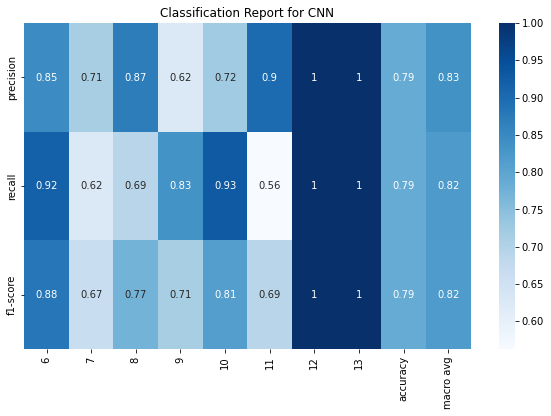

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


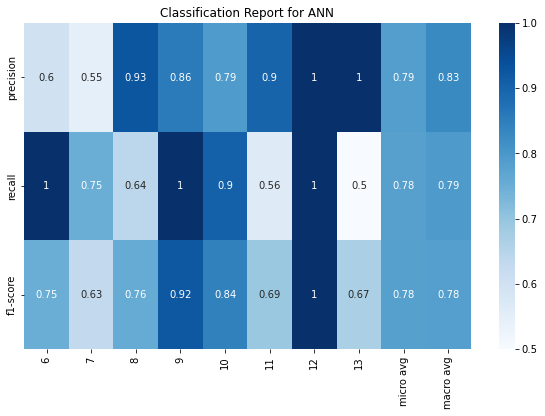

In [ ]:
# Function to plot classification report
def plot_classification_report(y_true, y_pred, classes, model_name):
    # Use only the labels that are present in y_true
    unique_labels = np.unique(y_true)
    target_names = [classes[i] for i in unique_labels]
    
    # Generate the classification report
    report = classification_report(y_true, y_pred, output_dict=True, labels=unique_labels, target_names=target_names)
    
    df = pd.DataFrame(report).transpose()
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.iloc[:-1, :-1].T, annot=True, cmap="Blues")
    plt.title(f'Classification Report for {model_name}')
    plt.show()

# CNN Predictions and Classification Report Plot
cnn_predictions = np.argmax(cnn_model.predict(test_features_cnn), axis=1)
plot_classification_report(test_labels_encoded, cnn_predictions, label_encoder.classes_, "CNN")

# ANN Predictions and Classification Report Plot
ann_predictions = np.argmax(ann_model.predict(test_features_normalized), axis=1)
plot_classification_report(test_labels_encoded, ann_predictions, label_encoder.classes_, "ANN")
